In [14]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
#"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv"
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

<h1>Make Multivariable Dataset</h1>
<h2>Load Chinook Data</h2>

In [15]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
#     print(salmon_copy)
    king_data = salmon_copy.filter(["date","king"], axis=1)
#     print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [16]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
    king_all_copy, king_data= load_data(abdul_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [17]:
data_copy = king_all_copy
print(data_copy['date'])
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

0       1939-01-01
1       1939-01-02
2       1939-01-03
3       1939-01-04
4       1939-01-05
           ...    
24364   2020-12-25
24365   2020-12-26
24366   2020-12-27
24367   2020-12-28
24368   2020-12-29
Name: date, Length: 24369, dtype: datetime64[ns]


,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [18]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [19]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [20]:
data_copy

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [21]:
master_data = data_copy
master_data

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [22]:
master_data = master_data[132:]

In [23]:
master_data

,date,king
132,1950-01-31,0
133,1950-02-28,0
134,1950-03-31,21
135,1950-04-30,6630
136,1950-05-31,50638
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [24]:
master_data.reset_index(inplace=True)

In [25]:
master_data = master_data.drop(labels='index', axis=1)

In [26]:
print(master_data)

          date    king
0   1950-01-31       0
1   1950-02-28       0
2   1950-03-31      21
3   1950-04-30    6630
4   1950-05-31   50638
..         ...     ...
847 2020-08-31  105269
848 2020-09-30  254930
849 2020-10-31   30917
850 2020-11-30     843
851 2020-12-31       9

[852 rows x 2 columns]


In [27]:
# type(data_copy['date'])
# # data_copy['date'].astype(p)

<h2>Load Covariate Data and Concat to Master_Data</h2>

In [28]:
def load_cov_set(pathname):
    data = pd.read_csv(pathname)
    return data

In [29]:
ismael_path_cov = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/covariates.csv'
chris_path_cov = '/Users/chrisshell/Desktop/Stanford/SalmonData/Environmental Variables/salmon_env_use.csv'
abdul_path_cov= '/Users/abdul/Downloads/SalmonNet/salmon_env_use.csv'
cov_data = load_cov_set(abdul_path_cov)
cov_data

,year,month,upwelling,noi,npgo,pdo,oni
0,1950,1,-16,2.644,-2.190,-1.61,-1.40
1,1950,2,-166,2.077,-1.450,-2.17,-1.20
2,1950,3,-49,3.091,-0.970,-1.89,-1.10
3,1950,4,-4,1.923,-0.860,-1.99,-1.20
4,1950,5,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020,8,43,-0.463,-1.422,-1.32,-0.57
848,2020,9,-1,-0.276,-1.161,-1.03,-0.89
849,2020,10,10,1.612,-1.476,-0.62,-1.17
850,2020,11,-43,1.998,-1.710,-1.58,-1.27


In [30]:
upwelling = cov_data["upwelling"]
master_data = master_data.join(upwelling)
master_data

,date,king,upwelling
0,1950-01-31,0,-16
1,1950-02-28,0,-166
2,1950-03-31,21,-49
3,1950-04-30,6630,-4
4,1950-05-31,50638,49
...,...,...,...
847,2020-08-31,105269,43
848,2020-09-30,254930,-1
849,2020-10-31,30917,10
850,2020-11-30,843,-43


In [31]:
noi = cov_data["noi"]
master_data = master_data.join(noi)
master_data

,date,king,upwelling,noi
0,1950-01-31,0,-16,2.644
1,1950-02-28,0,-166,2.077
2,1950-03-31,21,-49,3.091
3,1950-04-30,6630,-4,1.923
4,1950-05-31,50638,49,2.211
...,...,...,...,...
847,2020-08-31,105269,43,-0.463
848,2020-09-30,254930,-1,-0.276
849,2020-10-31,30917,10,1.612
850,2020-11-30,843,-43,1.998


In [32]:
npgo = cov_data["npgo"]
master_data = master_data.join(npgo)
master_data

,date,king,upwelling,noi,npgo
0,1950-01-31,0,-16,2.644,-2.190
1,1950-02-28,0,-166,2.077,-1.450
2,1950-03-31,21,-49,3.091,-0.970
3,1950-04-30,6630,-4,1.923,-0.860
4,1950-05-31,50638,49,2.211,-0.630
...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422
848,2020-09-30,254930,-1,-0.276,-1.161
849,2020-10-31,30917,10,1.612,-1.476
850,2020-11-30,843,-43,1.998,-1.710


In [33]:
pdo = cov_data["pdo"]
master_data = master_data.join(pdo)
master_data

,date,king,upwelling,noi,npgo,pdo
0,1950-01-31,0,-16,2.644,-2.190,-1.61
1,1950-02-28,0,-166,2.077,-1.450,-2.17
2,1950-03-31,21,-49,3.091,-0.970,-1.89
3,1950-04-30,6630,-4,1.923,-0.860,-1.99
4,1950-05-31,50638,49,2.211,-0.630,-3.19
...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03
849,2020-10-31,30917,10,1.612,-1.476,-0.62
850,2020-11-30,843,-43,1.998,-1.710,-1.58


In [34]:
oni = cov_data["oni "]
master_data = master_data.join(oni)
master_data
# cov_data.columns

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [35]:
master_data = master_data.rename(columns={"oni ": "oni"})
master_data

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [36]:
# ismael_path_pdo = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/pdo.csv'
# pdo_data = load_cov_set(ismael_path_pdo)
# pdo_data

In [37]:
# master_data = data_copy

In [38]:
# pdo = pdo_data["PDO"]
# pdo = pdo[:984]
# pdo
# master_data = master_data.join(pdo)
# # master_data
# # master_data = master_data[:984]
# # master_data = master_data.reindex(columns=["Date", "Month", "king", "PDO"])
# # master_data

In [39]:
# # master_data.columns = ['year', 'month', 'king', 'pdo']
# master_data

In [40]:
# master_data

In [41]:
# master_data['year']=pd.to_datetime(master_data[['year','month']])
# master_data.set_index('date', inplace=True)
# master_data.index = pd.to_datetime(master_data.index)
# master_data

<h2> Load and Concat NOI data </h2>

In [42]:
# ismael_path_noi = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/noi.csv'
# noi_data = load_cov_set(ismael_path_noi)
# noi_data = noi_data[:877]
# noi_data = noi_data.drop(labels=0, axis=0)
# noi_data.reset_index()
# print(noi_data)
# print(noi_data['noix'])
# # noi_data = noi_data.drop(columns="index")

In [43]:
# noi = noi_data["noix"]
# # noi
# print(master_data)
# master_data = master_data[120:]
# print(master_data)
# master_data.reset_index()
# master_data = master_data.join(noi)

In [44]:
# master_data = master_data.reset_index()

In [45]:
# master_data
# master_data = master_data.drop(labels="index", axis=1)

In [46]:
# master_data.head(700)

In [47]:
master_data.set_index('date', inplace=True)
master_data.index = pd.to_datetime(master_data.index)
master_data

,king,upwelling,noi,npgo,pdo,oni
date,,,,,,
1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...
2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17


In [48]:
master_data.to_csv('master_data.csv')

In [69]:
checkpoint_filepath = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/checkpoint'
chris_checkpoint_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Checkpoint'
abdul_checkpoint_path = '/Users/abdul/Downloads/SalmonNet/Checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=abdul_checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

<h2>Let's plot each series</h2>

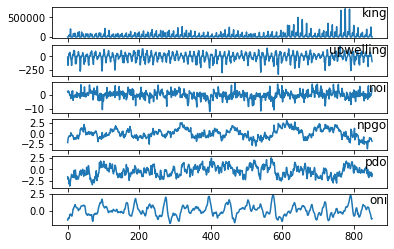

In [70]:
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=.5, loc='right')
    i += 1
plt.show()

<h2>Make Series into Train and Test Set with inputs and ouptuts</h2>

In [71]:
# convert series to supervised learning
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_months = 6
n_features = 6
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6    0.000006   0.520913   0.710488   0.220877   0.329032   0.119048   
7    0.000006   0.079848   0.683284   0.332829   0.238710   0.166667   
8    0.000035   0.399240   0.731936   0.405446   0.283871   0.190476   
9    0.009241   0.566540   0.675895   0.422088   0.267742   0.166667   
10   0.070540   0.764259   0.689713   0.456883   0.074194   0.190476   

    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  ...  var3(t-1)  var4(t-1)  \
6    0.000006   0.079848   0.683284   0.332829  ...   0.632281   0.464448   
7    0.000035   0.399240   0.731936   0.405446  ...   0.567508   0.440242   
8    0.009241   0.566540   0.675895   0.422088  ...   0.572306   0.468986   
9    0.070540   0.764259   0.689713   0.456883  ...   0.591786   0.461422   
10   0.023221   0.703422   0.632281   0.464448  ...   0.461760   0.570348   

    var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
6    0.182258   0.238095  

In [72]:
# split into train and test sets
values = reframed.values
n_train_months = 66 * 12 # MENTAL NOTE: IF ERROR IN MOTH TO YEAR CHECK THIS
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(792, 6, 6) (792,) (54, 6, 6) (54,)


In [73]:
X_train, X_dev, y_train, y_dev = train_test_split(train_X, train_y, test_size=0.10, shuffle=False)

In [74]:
print(X_dev.shape)
print(y_dev.shape)
print(X_train.shape)
print(y_train.shape)
print(test_X.shape)
print(test_y.shape)

(80, 6, 6)
(80,)
(712, 6, 6)
(712,)
(54, 6, 6)
(54,)


Epoch 1/1000
8/8 - 5s - loss: 0.0552 - root_mean_squared_error: 0.2350 - val_loss: 0.0547 - val_root_mean_squared_error: 0.2339
Epoch 2/1000
8/8 - 0s - loss: 0.0135 - root_mean_squared_error: 0.1162 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1981
Epoch 3/1000
8/8 - 0s - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0403 - val_root_mean_squared_error: 0.2008
Epoch 4/1000
8/8 - 0s - loss: 0.0139 - root_mean_squared_error: 0.1178 - val_loss: 0.0484 - val_root_mean_squared_error: 0.2199
Epoch 5/1000
8/8 - 0s - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1938
Epoch 6/1000
8/8 - 0s - loss: 0.0102 - root_mean_squared_error: 0.1012 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2002
Epoch 7/1000
8/8 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1973
Epoch 8/1000
8/8 - 0s - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.0378 - val_root_mea

Epoch 40/1000
8/8 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1806
Epoch 41/1000
8/8 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1802
Epoch 42/1000
8/8 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1797
Epoch 43/1000
8/8 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1793
Epoch 44/1000
8/8 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1788
Epoch 45/1000
8/8 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1783
Epoch 46/1000
8/8 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1779
Epoch 47/1000
8/8 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0315 - val_

Epoch 79/1000
8/8 - 0s - loss: 0.0052 - root_mean_squared_error: 0.0721 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1593
Epoch 80/1000
8/8 - 0s - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1588
Epoch 81/1000
8/8 - 0s - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1582
Epoch 82/1000
8/8 - 0s - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1577
Epoch 83/1000
8/8 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1572
Epoch 84/1000
8/8 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1568
Epoch 85/1000
8/8 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1563
Epoch 86/1000
8/8 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0243 - val_

Epoch 118/1000
8/8 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1417
Epoch 119/1000
8/8 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1412
Epoch 120/1000
8/8 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1407
Epoch 121/1000
8/8 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0626 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1404
Epoch 122/1000
8/8 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0627 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1402
Epoch 123/1000
8/8 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1400
Epoch 124/1000
8/8 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1399
Epoch 125/1000
8/8 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.019

Epoch 157/1000
8/8 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1444
Epoch 158/1000
8/8 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1356
Epoch 159/1000
8/8 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1296
Epoch 160/1000
8/8 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0626 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 161/1000
8/8 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0592 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1302
Epoch 162/1000
8/8 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1272
Epoch 163/1000
8/8 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1246
Epoch 164/1000
8/8 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.016

Epoch 196/1000
8/8 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 197/1000
8/8 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 198/1000
8/8 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0538 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 199/1000
8/8 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 200/1000
8/8 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1107
Epoch 201/1000
8/8 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 202/1000
8/8 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 203/1000
8/8 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.013

Epoch 235/1000
8/8 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 236/1000
8/8 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 237/1000
8/8 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990
Epoch 238/1000
8/8 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0478 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 239/1000
8/8 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1024
Epoch 240/1000
8/8 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0968
Epoch 241/1000
8/8 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 242/1000
8/8 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.010

Epoch 274/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 275/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 276/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878
Epoch 277/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901
Epoch 278/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892
Epoch 279/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856
Epoch 280/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0399 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 281/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0381 - val_loss: 0.007

Epoch 313/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787
Epoch 314/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0339 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0766
Epoch 315/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0782
Epoch 316/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805
Epoch 317/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0757
Epoch 318/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0767
Epoch 319/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0778
Epoch 320/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0339 - val_loss: 0.005

Epoch 351/1000
8/8 - 0s - loss: 8.1587e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0675
Epoch 352/1000
8/8 - 0s - loss: 8.3820e-04 - root_mean_squared_error: 0.0290 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 353/1000
8/8 - 0s - loss: 8.4806e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0652
Epoch 354/1000
8/8 - 0s - loss: 8.8138e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677
Epoch 355/1000
8/8 - 0s - loss: 7.9344e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0655
Epoch 356/1000
8/8 - 0s - loss: 7.1315e-04 - root_mean_squared_error: 0.0267 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 357/1000
8/8 - 0s - loss: 8.1253e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0652
Epoch 358/1000
8/8 - 0s - loss: 8.0199e-04 - root_mean_squared

Epoch 389/1000
8/8 - 0s - loss: 7.4481e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 390/1000
8/8 - 0s - loss: 7.7623e-04 - root_mean_squared_error: 0.0279 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0604
Epoch 391/1000
8/8 - 0s - loss: 8.0290e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 392/1000
8/8 - 0s - loss: 7.4234e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 393/1000
8/8 - 0s - loss: 7.2038e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0593
Epoch 394/1000
8/8 - 0s - loss: 7.4386e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 395/1000
8/8 - 0s - loss: 6.7740e-04 - root_mean_squared_error: 0.0260 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 396/1000
8/8 - 0s - loss: 6.4185e-04 - root_mean_squared

Epoch 427/1000
8/8 - 0s - loss: 5.5506e-04 - root_mean_squared_error: 0.0236 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0500
Epoch 428/1000
8/8 - 0s - loss: 5.1805e-04 - root_mean_squared_error: 0.0228 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 429/1000
8/8 - 0s - loss: 4.6146e-04 - root_mean_squared_error: 0.0215 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 430/1000
8/8 - 0s - loss: 4.9479e-04 - root_mean_squared_error: 0.0222 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483
Epoch 431/1000
8/8 - 0s - loss: 5.0787e-04 - root_mean_squared_error: 0.0225 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0495
Epoch 432/1000
8/8 - 0s - loss: 5.1604e-04 - root_mean_squared_error: 0.0227 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 433/1000
8/8 - 0s - loss: 5.0801e-04 - root_mean_squared_error: 0.0225 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0469
Epoch 434/1000
8/8 - 0s - loss: 5.9879e-04 - root_mean_squared

Epoch 465/1000
8/8 - 0s - loss: 2.7861e-04 - root_mean_squared_error: 0.0167 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0404
Epoch 466/1000
8/8 - 0s - loss: 2.6559e-04 - root_mean_squared_error: 0.0163 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 467/1000
8/8 - 0s - loss: 2.7664e-04 - root_mean_squared_error: 0.0166 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 468/1000
8/8 - 0s - loss: 2.6313e-04 - root_mean_squared_error: 0.0162 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 469/1000
8/8 - 0s - loss: 2.6530e-04 - root_mean_squared_error: 0.0163 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 470/1000
8/8 - 0s - loss: 2.6878e-04 - root_mean_squared_error: 0.0164 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 471/1000
8/8 - 0s - loss: 2.6454e-04 - root_mean_squared_error: 0.0163 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 472/1000
8/8 - 0s - loss: 2.9984e-04 - root_mean_squared

Epoch 503/1000
8/8 - 0s - loss: 3.0253e-04 - root_mean_squared_error: 0.0174 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 504/1000
8/8 - 0s - loss: 3.0466e-04 - root_mean_squared_error: 0.0175 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 505/1000
8/8 - 0s - loss: 3.3215e-04 - root_mean_squared_error: 0.0182 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 506/1000
8/8 - 0s - loss: 2.9359e-04 - root_mean_squared_error: 0.0171 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 507/1000
8/8 - 0s - loss: 3.2695e-04 - root_mean_squared_error: 0.0181 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 508/1000
8/8 - 0s - loss: 3.9066e-04 - root_mean_squared_error: 0.0198 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 509/1000
8/8 - 0s - loss: 3.1034e-04 - root_mean_squared_error: 0.0176 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 510/1000
8/8 - 0s - loss: 3.7261e-04 - root_mean_squared

Epoch 541/1000
8/8 - 0s - loss: 3.6706e-04 - root_mean_squared_error: 0.0192 - val_loss: 9.8937e-04 - val_root_mean_squared_error: 0.0315
Epoch 542/1000
8/8 - 0s - loss: 3.1464e-04 - root_mean_squared_error: 0.0177 - val_loss: 8.6491e-04 - val_root_mean_squared_error: 0.0294
Epoch 543/1000
8/8 - 0s - loss: 2.6149e-04 - root_mean_squared_error: 0.0162 - val_loss: 9.3343e-04 - val_root_mean_squared_error: 0.0306
Epoch 544/1000
8/8 - 0s - loss: 2.8164e-04 - root_mean_squared_error: 0.0168 - val_loss: 9.1143e-04 - val_root_mean_squared_error: 0.0302
Epoch 545/1000
8/8 - 0s - loss: 2.8956e-04 - root_mean_squared_error: 0.0170 - val_loss: 8.5561e-04 - val_root_mean_squared_error: 0.0293
Epoch 546/1000
8/8 - 0s - loss: 2.5492e-04 - root_mean_squared_error: 0.0160 - val_loss: 7.8150e-04 - val_root_mean_squared_error: 0.0280
Epoch 547/1000
8/8 - 0s - loss: 2.5008e-04 - root_mean_squared_error: 0.0158 - val_loss: 8.5941e-04 - val_root_mean_squared_error: 0.0293
Epoch 548/1000
8/8 - 0s - loss: 2.

Epoch 578/1000
8/8 - 0s - loss: 5.1391e-04 - root_mean_squared_error: 0.0227 - val_loss: 9.5800e-04 - val_root_mean_squared_error: 0.0310
Epoch 579/1000
8/8 - 0s - loss: 4.2748e-04 - root_mean_squared_error: 0.0207 - val_loss: 8.5404e-04 - val_root_mean_squared_error: 0.0292
Epoch 580/1000
8/8 - 0s - loss: 3.2486e-04 - root_mean_squared_error: 0.0180 - val_loss: 6.4379e-04 - val_root_mean_squared_error: 0.0254
Epoch 581/1000
8/8 - 0s - loss: 1.9930e-04 - root_mean_squared_error: 0.0141 - val_loss: 6.3951e-04 - val_root_mean_squared_error: 0.0253
Epoch 582/1000
8/8 - 0s - loss: 2.2703e-04 - root_mean_squared_error: 0.0151 - val_loss: 6.3264e-04 - val_root_mean_squared_error: 0.0252
Epoch 583/1000
8/8 - 0s - loss: 2.1243e-04 - root_mean_squared_error: 0.0146 - val_loss: 5.8228e-04 - val_root_mean_squared_error: 0.0241
Epoch 584/1000
8/8 - 0s - loss: 1.8163e-04 - root_mean_squared_error: 0.0135 - val_loss: 5.2718e-04 - val_root_mean_squared_error: 0.0230
Epoch 585/1000
8/8 - 0s - loss: 1.

Epoch 616/1000
8/8 - 0s - loss: 6.9216e-04 - root_mean_squared_error: 0.0263 - val_loss: 6.1622e-04 - val_root_mean_squared_error: 0.0248
Epoch 617/1000
8/8 - 0s - loss: 5.6968e-04 - root_mean_squared_error: 0.0239 - val_loss: 8.6108e-04 - val_root_mean_squared_error: 0.0293
Epoch 618/1000
8/8 - 0s - loss: 4.7152e-04 - root_mean_squared_error: 0.0217 - val_loss: 6.4090e-04 - val_root_mean_squared_error: 0.0253
Epoch 619/1000
8/8 - 0s - loss: 5.8695e-04 - root_mean_squared_error: 0.0242 - val_loss: 7.8550e-04 - val_root_mean_squared_error: 0.0280
Epoch 620/1000
8/8 - 0s - loss: 4.3608e-04 - root_mean_squared_error: 0.0209 - val_loss: 6.9267e-04 - val_root_mean_squared_error: 0.0263
Epoch 621/1000
8/8 - 0s - loss: 3.1353e-04 - root_mean_squared_error: 0.0177 - val_loss: 5.1927e-04 - val_root_mean_squared_error: 0.0228
Epoch 622/1000
8/8 - 0s - loss: 2.1553e-04 - root_mean_squared_error: 0.0147 - val_loss: 4.3980e-04 - val_root_mean_squared_error: 0.0210
Epoch 623/1000
8/8 - 0s - loss: 2.

Epoch 653/1000
8/8 - 0s - loss: 1.4522e-04 - root_mean_squared_error: 0.0121 - val_loss: 2.5352e-04 - val_root_mean_squared_error: 0.0159
Epoch 654/1000
8/8 - 0s - loss: 1.7439e-04 - root_mean_squared_error: 0.0132 - val_loss: 3.0948e-04 - val_root_mean_squared_error: 0.0176
Epoch 655/1000
8/8 - 0s - loss: 2.2321e-04 - root_mean_squared_error: 0.0149 - val_loss: 3.1291e-04 - val_root_mean_squared_error: 0.0177
Epoch 656/1000
8/8 - 0s - loss: 2.1939e-04 - root_mean_squared_error: 0.0148 - val_loss: 3.3933e-04 - val_root_mean_squared_error: 0.0184
Epoch 657/1000
8/8 - 0s - loss: 2.5396e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.7647e-04 - val_root_mean_squared_error: 0.0194
Epoch 658/1000
8/8 - 0s - loss: 2.0202e-04 - root_mean_squared_error: 0.0142 - val_loss: 3.3041e-04 - val_root_mean_squared_error: 0.0182
Epoch 659/1000
8/8 - 0s - loss: 2.6174e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.8429e-04 - val_root_mean_squared_error: 0.0196
Epoch 660/1000
8/8 - 0s - loss: 2.

Epoch 691/1000
8/8 - 0s - loss: 9.6406e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.7879e-04 - val_root_mean_squared_error: 0.0134
Epoch 692/1000
8/8 - 0s - loss: 1.7296e-04 - root_mean_squared_error: 0.0132 - val_loss: 1.8829e-04 - val_root_mean_squared_error: 0.0137
Epoch 693/1000
8/8 - 0s - loss: 1.8979e-04 - root_mean_squared_error: 0.0138 - val_loss: 3.2834e-04 - val_root_mean_squared_error: 0.0181
Epoch 694/1000
8/8 - 0s - loss: 2.7172e-04 - root_mean_squared_error: 0.0165 - val_loss: 2.2633e-04 - val_root_mean_squared_error: 0.0150
Epoch 695/1000
8/8 - 0s - loss: 2.9754e-04 - root_mean_squared_error: 0.0172 - val_loss: 2.8896e-04 - val_root_mean_squared_error: 0.0170
Epoch 696/1000
8/8 - 0s - loss: 2.5797e-04 - root_mean_squared_error: 0.0161 - val_loss: 4.1208e-04 - val_root_mean_squared_error: 0.0203
Epoch 697/1000
8/8 - 0s - loss: 2.6368e-04 - root_mean_squared_error: 0.0162 - val_loss: 1.6427e-04 - val_root_mean_squared_error: 0.0128
Epoch 698/1000
8/8 - 0s - loss: 2.

Epoch 728/1000
8/8 - 0s - loss: 1.2338e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.9556e-04 - val_root_mean_squared_error: 0.0140
Epoch 729/1000
8/8 - 0s - loss: 1.3552e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.4993e-04 - val_root_mean_squared_error: 0.0122
Epoch 730/1000
8/8 - 0s - loss: 1.7210e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.3693e-04 - val_root_mean_squared_error: 0.0117
Epoch 731/1000
8/8 - 0s - loss: 2.0903e-04 - root_mean_squared_error: 0.0145 - val_loss: 2.9048e-04 - val_root_mean_squared_error: 0.0170
Epoch 732/1000
8/8 - 0s - loss: 2.5713e-04 - root_mean_squared_error: 0.0160 - val_loss: 2.4112e-04 - val_root_mean_squared_error: 0.0155
Epoch 733/1000
8/8 - 0s - loss: 1.6474e-04 - root_mean_squared_error: 0.0128 - val_loss: 2.2608e-04 - val_root_mean_squared_error: 0.0150
Epoch 734/1000
8/8 - 0s - loss: 1.2684e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.6207e-04 - val_root_mean_squared_error: 0.0127
Epoch 735/1000
8/8 - 0s - loss: 1.

Epoch 766/1000
8/8 - 0s - loss: 2.5844e-04 - root_mean_squared_error: 0.0161 - val_loss: 1.6470e-04 - val_root_mean_squared_error: 0.0128
Epoch 767/1000
8/8 - 0s - loss: 1.9927e-04 - root_mean_squared_error: 0.0141 - val_loss: 1.0736e-04 - val_root_mean_squared_error: 0.0104
Epoch 768/1000
8/8 - 0s - loss: 1.9238e-04 - root_mean_squared_error: 0.0139 - val_loss: 3.2440e-04 - val_root_mean_squared_error: 0.0180
Epoch 769/1000
8/8 - 0s - loss: 1.8343e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.2925e-04 - val_root_mean_squared_error: 0.0114
Epoch 770/1000
8/8 - 0s - loss: 1.1388e-04 - root_mean_squared_error: 0.0107 - val_loss: 7.4283e-05 - val_root_mean_squared_error: 0.0086
Epoch 771/1000
8/8 - 0s - loss: 1.1949e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.9374e-04 - val_root_mean_squared_error: 0.0139
Epoch 772/1000
8/8 - 0s - loss: 1.6490e-04 - root_mean_squared_error: 0.0128 - val_loss: 1.7152e-04 - val_root_mean_squared_error: 0.0131
Epoch 773/1000
8/8 - 0s - loss: 1.

Epoch 803/1000
8/8 - 0s - loss: 1.0508e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.0843e-04 - val_root_mean_squared_error: 0.0104
Epoch 804/1000
8/8 - 0s - loss: 7.8360e-05 - root_mean_squared_error: 0.0089 - val_loss: 1.0134e-04 - val_root_mean_squared_error: 0.0101
Epoch 805/1000
8/8 - 0s - loss: 6.5363e-05 - root_mean_squared_error: 0.0081 - val_loss: 7.2138e-05 - val_root_mean_squared_error: 0.0085
Epoch 806/1000
8/8 - 0s - loss: 6.5962e-05 - root_mean_squared_error: 0.0081 - val_loss: 8.0655e-05 - val_root_mean_squared_error: 0.0090
Epoch 807/1000
8/8 - 0s - loss: 7.3424e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.0725e-04 - val_root_mean_squared_error: 0.0104
Epoch 808/1000
8/8 - 0s - loss: 6.6687e-05 - root_mean_squared_error: 0.0082 - val_loss: 5.1882e-05 - val_root_mean_squared_error: 0.0072
Epoch 809/1000
8/8 - 0s - loss: 5.0969e-05 - root_mean_squared_error: 0.0071 - val_loss: 5.6166e-05 - val_root_mean_squared_error: 0.0075
Epoch 810/1000
8/8 - 0s - loss: 6.

Epoch 841/1000
8/8 - 0s - loss: 7.7570e-05 - root_mean_squared_error: 0.0088 - val_loss: 5.6409e-05 - val_root_mean_squared_error: 0.0075
Epoch 842/1000
8/8 - 0s - loss: 7.7060e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.0204e-04 - val_root_mean_squared_error: 0.0101
Epoch 843/1000
8/8 - 0s - loss: 9.2355e-05 - root_mean_squared_error: 0.0096 - val_loss: 8.4486e-05 - val_root_mean_squared_error: 0.0092
Epoch 844/1000
8/8 - 0s - loss: 6.2241e-05 - root_mean_squared_error: 0.0079 - val_loss: 6.0324e-05 - val_root_mean_squared_error: 0.0078
Epoch 845/1000
8/8 - 0s - loss: 5.0848e-05 - root_mean_squared_error: 0.0071 - val_loss: 7.2294e-05 - val_root_mean_squared_error: 0.0085
Epoch 846/1000
8/8 - 0s - loss: 7.9901e-05 - root_mean_squared_error: 0.0089 - val_loss: 9.9241e-05 - val_root_mean_squared_error: 0.0100
Epoch 847/1000
8/8 - 0s - loss: 8.5088e-05 - root_mean_squared_error: 0.0092 - val_loss: 8.4345e-05 - val_root_mean_squared_error: 0.0092
Epoch 848/1000
8/8 - 0s - loss: 7.

Epoch 878/1000
8/8 - 0s - loss: 1.9111e-04 - root_mean_squared_error: 0.0138 - val_loss: 2.0524e-04 - val_root_mean_squared_error: 0.0143
Epoch 879/1000
8/8 - 0s - loss: 1.8296e-04 - root_mean_squared_error: 0.0135 - val_loss: 2.6022e-04 - val_root_mean_squared_error: 0.0161
Epoch 880/1000
8/8 - 0s - loss: 1.2722e-04 - root_mean_squared_error: 0.0113 - val_loss: 9.8816e-05 - val_root_mean_squared_error: 0.0099
Epoch 881/1000
8/8 - 0s - loss: 7.1811e-05 - root_mean_squared_error: 0.0085 - val_loss: 5.5717e-05 - val_root_mean_squared_error: 0.0075
Epoch 882/1000
8/8 - 0s - loss: 8.6887e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.1571e-04 - val_root_mean_squared_error: 0.0108
Epoch 883/1000
8/8 - 0s - loss: 1.2101e-04 - root_mean_squared_error: 0.0110 - val_loss: 8.3742e-05 - val_root_mean_squared_error: 0.0092
Epoch 884/1000
8/8 - 0s - loss: 1.0857e-04 - root_mean_squared_error: 0.0104 - val_loss: 5.5412e-05 - val_root_mean_squared_error: 0.0074
Epoch 885/1000
8/8 - 0s - loss: 1.

Epoch 916/1000
8/8 - 0s - loss: 7.7828e-05 - root_mean_squared_error: 0.0088 - val_loss: 3.7054e-05 - val_root_mean_squared_error: 0.0061
Epoch 917/1000
8/8 - 0s - loss: 5.4481e-05 - root_mean_squared_error: 0.0074 - val_loss: 4.5075e-05 - val_root_mean_squared_error: 0.0067
Epoch 918/1000
8/8 - 0s - loss: 5.2401e-05 - root_mean_squared_error: 0.0072 - val_loss: 8.2398e-05 - val_root_mean_squared_error: 0.0091
Epoch 919/1000
8/8 - 0s - loss: 5.4797e-05 - root_mean_squared_error: 0.0074 - val_loss: 4.4709e-05 - val_root_mean_squared_error: 0.0067
Epoch 920/1000
8/8 - 0s - loss: 4.8398e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.9260e-05 - val_root_mean_squared_error: 0.0054
Epoch 921/1000
8/8 - 0s - loss: 4.8915e-05 - root_mean_squared_error: 0.0070 - val_loss: 4.6832e-05 - val_root_mean_squared_error: 0.0068
Epoch 922/1000
8/8 - 0s - loss: 6.5460e-05 - root_mean_squared_error: 0.0081 - val_loss: 6.7386e-05 - val_root_mean_squared_error: 0.0082
Epoch 923/1000
8/8 - 0s - loss: 8.

Epoch 953/1000
8/8 - 0s - loss: 3.0605e-04 - root_mean_squared_error: 0.0175 - val_loss: 1.8860e-04 - val_root_mean_squared_error: 0.0137
Epoch 954/1000
8/8 - 0s - loss: 2.9196e-04 - root_mean_squared_error: 0.0171 - val_loss: 1.5564e-04 - val_root_mean_squared_error: 0.0125
Epoch 955/1000
8/8 - 0s - loss: 2.2637e-04 - root_mean_squared_error: 0.0150 - val_loss: 2.1289e-04 - val_root_mean_squared_error: 0.0146
Epoch 956/1000
8/8 - 0s - loss: 1.4026e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.5792e-04 - val_root_mean_squared_error: 0.0126
Epoch 957/1000
8/8 - 0s - loss: 9.2768e-05 - root_mean_squared_error: 0.0096 - val_loss: 6.4083e-05 - val_root_mean_squared_error: 0.0080
Epoch 958/1000
8/8 - 0s - loss: 5.9903e-05 - root_mean_squared_error: 0.0077 - val_loss: 6.9051e-05 - val_root_mean_squared_error: 0.0083
Epoch 959/1000
8/8 - 0s - loss: 3.0673e-05 - root_mean_squared_error: 0.0055 - val_loss: 4.7544e-05 - val_root_mean_squared_error: 0.0069
Epoch 960/1000
8/8 - 0s - loss: 2.

Epoch 991/1000
8/8 - 0s - loss: 5.0656e-05 - root_mean_squared_error: 0.0071 - val_loss: 4.6262e-05 - val_root_mean_squared_error: 0.0068
Epoch 992/1000
8/8 - 0s - loss: 5.6202e-05 - root_mean_squared_error: 0.0075 - val_loss: 4.5314e-05 - val_root_mean_squared_error: 0.0067
Epoch 993/1000
8/8 - 0s - loss: 7.1259e-05 - root_mean_squared_error: 0.0084 - val_loss: 8.3427e-05 - val_root_mean_squared_error: 0.0091
Epoch 994/1000
8/8 - 0s - loss: 9.3099e-05 - root_mean_squared_error: 0.0096 - val_loss: 6.9029e-05 - val_root_mean_squared_error: 0.0083
Epoch 995/1000
8/8 - 0s - loss: 8.1970e-05 - root_mean_squared_error: 0.0091 - val_loss: 6.3711e-05 - val_root_mean_squared_error: 0.0080
Epoch 996/1000
8/8 - 0s - loss: 8.3448e-05 - root_mean_squared_error: 0.0091 - val_loss: 9.7956e-05 - val_root_mean_squared_error: 0.0099
Epoch 997/1000
8/8 - 0s - loss: 9.7425e-05 - root_mean_squared_error: 0.0099 - val_loss: 9.5813e-05 - val_root_mean_squared_error: 0.0098
Epoch 998/1000
8/8 - 0s - loss: 6.

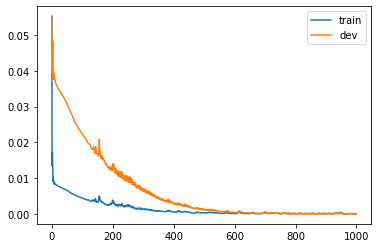

In [75]:
# design network
model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit network
#  
history = model.fit(train_X, train_y, epochs=1000, batch_size=100, validation_data=(X_dev, y_dev), verbose=2, shuffle=False, callbacks=[model_checkpoint_callback])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [76]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))

In [77]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [78]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [79]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
def month_to_year(month_preds):
    month_preds = month_preds[6:]
    year_preds = []
    for i in range(12, len(month_preds) + 1, 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The test root mean squared error is {}.".format(rmse))

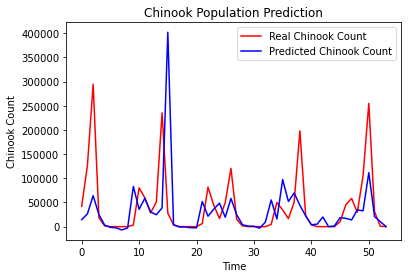

The test root mean squared error is 77656.691868763.


In [80]:
plot_predictions(inv_y, inv_yhat)
return_rmse(inv_y, inv_yhat)

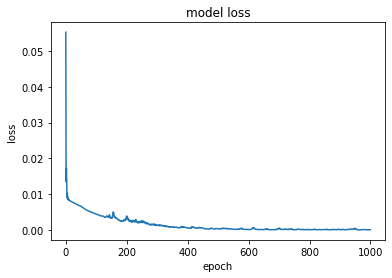

In [81]:
plot_loss(history)

In [82]:
preds = month_to_year(inv_yhat).astype(np.int64)
actual = month_to_year(inv_y).astype(np.int64)
print(preds)
print(actual)

    Count
0  665158
1  260097
2  372892
3  280885
    Count
0  488981
1  336030
2  381773
3  535746


In [83]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_abdul_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)

    Count
0  498710
1  439060
2  294840
3  347600


In [84]:
return_rmse(actual, traditional)

The test root mean squared error is 115829.72216361394.


In [85]:
return_rmse(actual, preds)

The test root mean squared error is 159559.67324170604.


In [86]:
# def create_train_test(king_all):
#     king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
#     king_training = king_all[king_training_parse]
#     king_training = king_training.reset_index()
#     king_training = king_training.drop('index', axis=1)
    
#     king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
#     king_test = king_all[king_test_parse]
#     king_test = king_test.reset_index()
#     king_test = king_test.drop('index', axis=1)
#     print(king_test.shape)
    
#     # Normalizing Data
#     king_training[king_training["king"] < 0] = 0 
# #     print('max val king_train:')
#     print(max(king_training['king']))
#     king_test[king_test["king"] < 0] = 0
# #     print('max val king_test:')
#     print(max(king_test['king']))
#     king_train_pre = king_training["king"].to_frame()
# #     print(king_train_norm)
#     king_test_pre = king_test["king"].to_frame()
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     king_train_norm = scaler.fit_transform(king_train_pre)
#     king_test_norm = scaler.fit_transform(king_test_pre)
#     print('king_test_norm')
#     print(king_test_norm.shape)
#     print('king_train_norm')
#     print(king_train_norm.shape)
#     #king_train_norm = (king_training["king"] - np.min(king_training["king"])) / (np.max(king_training["king"]) - np.min(king_training["king"]))
#     #print(type(king_train_norm))
#     #king_train_norm = king_train_norm.to_frame()
#     x_train = []
#     y_train = []
#     x_test = []
#     y_test = []
#     y_test_not_norm = []
#     y_train_not_norm = []
    
#     # Todo: Experiment with input size of input (ex. 30 days)
    
#     for i in range(6,924): # 30
#         x_train.append(king_train_norm[i-6:i])
#         y_train.append(king_train_norm[i])
#     for i in range(6, 60):
#         x_test.append(king_test_norm[i-6:i])
#         y_test.append(king_test_norm[i])
    
#     # make y_test_not_norm
#     for i in range(6, 60):
#         y_test_not_norm.append(king_test['king'][i])
#     for i in range(6,924): # 30
#         y_train_not_norm.append(king_training['king'][i])
        
#     return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm

In [87]:
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(data_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test_not_norm = np.array(y_test_not_norm)
print(y_test.shape)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
print(y_test_not_norm.shape)
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))
print(y_train_not_norm.shape)
print(y_train.shape)


NameError: name 'create_train_test' is not defined

In [ ]:
# def load_pdo(pathname):
#     pdo_data = pd.read_csv(pathname)
# #     print(pdo_data.head())
#     return pdo_data

In [ ]:
# ismael_path_pdo = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/pdo.csv'
# pdo_data = load_pdo(ismael_path_pdo)

In [ ]:
# pdo = pdo_data["PDO"]
# data_copy = data_copy.join(pdo)

In [ ]:
# pdo_data

In [180]:
# print(data_copy)